# *Financial Q-Learning Trading Agent*

*Description*: I am going to explore the area of machine learning and quantitative analysis. I specifically want to see how agents can help us better understand trends and produce forecasts for how stock, index's and other asset prices change. This application project is an exploration of a time series model for prices with various different analysis and prediction models.

## Accessing our Trading Agent

In [1]:
#imports
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

## Trading Bot on Apple Share "AAPL"

In [2]:
import finance
import tradingbot

In [3]:
#APPLE STOCK 
symbol = 'AAPL.O'
#r = passive benchmarch investment
#s = strategy/bot
#m = momementum 
#v = rolling volitility
features = [symbol, 'r', 's', 'm', 'v']

In [4]:
a = 0
b = 1750
c = 250

In [5]:
learn_env = finance.Finance(symbol, features, window=20, lags=3,
                 leverage=1, min_performance=0.9, min_accuracy=0.475,
                 start=a, end=a + b, mu=None, std=None)

In [6]:
learn_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1750 entries, 2010-02-02 to 2017-01-12
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  1750 non-null   float64
 1   r       1750 non-null   float64
 2   s       1750 non-null   float64
 3   m       1750 non-null   float64
 4   v       1750 non-null   float64
 5   d       1750 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 95.7 KB


In [7]:
valid_env = finance.Finance(symbol, features=learn_env.features,
                            window=learn_env.window,
                            lags=learn_env.lags,
                            leverage=learn_env.leverage,
                            min_performance=0.0, min_accuracy=0.0,
                            start=a + b, end=a + b + c,
                            mu=learn_env.mu, std=learn_env.std)

In [8]:
valid_env.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2017-01-13 to 2018-01-10
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  250 non-null    float64
 1   r       250 non-null    float64
 2   s       250 non-null    float64
 3   m       250 non-null    float64
 4   v       250 non-null    float64
 5   d       250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [9]:
valid_env.data

,AAPL.O,r,s,m,v,d
Date,,,,,,
2017-01-13,119.0400,-0.0018,117.2325,0.0016,0.0050,0
2017-01-17,120.0000,0.0080,117.4415,0.0018,0.0051,1
2017-01-18,119.9900,-0.0001,117.6425,0.0017,0.0052,0
2017-01-19,119.7800,-0.0018,117.7995,0.0013,0.0051,0
2017-01-20,120.0000,0.0018,117.9520,0.0013,0.0051,1
...,...,...,...,...,...,...
2018-01-04,173.0300,0.0046,172.2430,0.0010,0.0102,1
2018-01-05,175.0000,0.0113,172.5425,0.0017,0.0104,1
2018-01-08,174.3500,-0.0037,172.7940,0.0015,0.0104,0


In [10]:
#hidden layers set to .001
tradingbot.set_seeds(100)
#grabbing bot #24
agent = tradingbot.TradingBot(24, 0.001, learn_env, valid_env)

In [11]:
episodes = 70

In [12]:
%time agent.learn(episodes)

episode: 11/70 | VALIDATION | treward:  247 | perf: 1.267 | eps: 0.93
episode: 22/70 | VALIDATION | treward:  247 | perf: 1.102 | eps: 0.83
episode: 33/70 | VALIDATION | treward:  247 | perf: 1.268 | eps: 0.75
episode: 44/70 | VALIDATION | treward:  247 | perf: 0.729 | eps: 0.67
episode: 55/70 | VALIDATION | treward:  247 | perf: 0.737 | eps: 0.60
episode: 66/70 | VALIDATION | treward:  247 | perf: 0.694 | eps: 0.54
episode: 70/70 | treward:  747 | perf: 0.864 | av: 877.0 | max: 1747
CPU times: user 1min 46s, sys: 4.92 s, total: 1min 51s
Wall time: 1min 44s


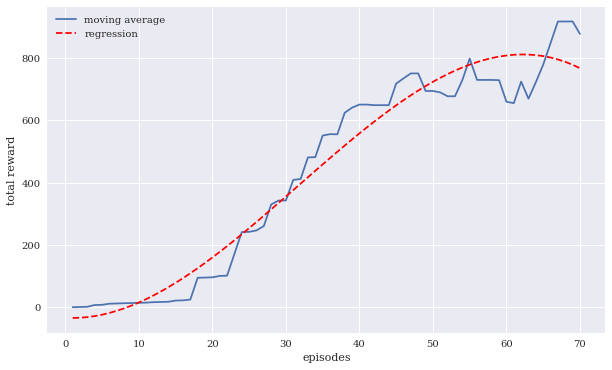

In [13]:
tradingbot.plot_treward(agent)

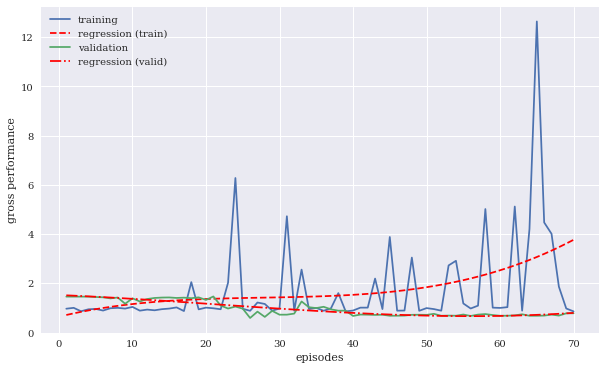

In [14]:
tradingbot.plot_performance(agent)

## Vectorized Backtesting

In [15]:
def reshape(s):
    return np.reshape(s, [1, learn_env.lags,
                          learn_env.n_features])

In [16]:
def backtest(agent, env):
    env.min_accuracy = 0.0
    env.min_performance = 0.0
    done = False
    env.data['p'] = 0
    state = env.reset()
    while not done:
        action = np.argmax(
            agent.model.predict(reshape(state))[0, 0])
        position = 1 if action == 1 else -1
        env.data.loc[:, 'p'].iloc[env.bar] = position
        state, reward, done, info = env.step(action)
    env.data['s'] = env.data['p'] * env.data['r'] * learn_env.leverage

In [17]:
env = agent.learn_env

In [18]:
backtest(agent, env)

In [19]:
env.data['p'].iloc[env.lags:].value_counts()

 1    1646
-1     101
Name: p, dtype: int64

In [20]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   4.3465
s   7.1090
dtype: float64

In [21]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

r   3.3465
s   6.1090
dtype: float64

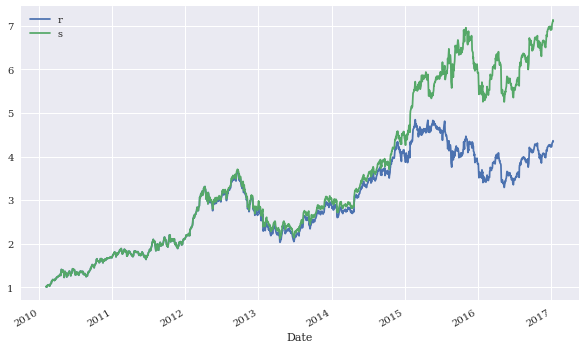

In [22]:
env.data[['r', 's']].iloc[env.lags:].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

In [23]:
test_env = finance.Finance(symbol, features=learn_env.features,
                           window=learn_env.window,
                           lags=learn_env.lags,
                           leverage=learn_env.leverage,
                           min_performance=0.0, min_accuracy=0.0,
                           start=a + b + c, end=None,
                           mu=learn_env.mu, std=learn_env.std)

In [24]:
env = test_env

In [25]:
backtest(agent, env)

In [26]:
env.data['p'].iloc[env.lags:].value_counts()

-1    399
 1     94
Name: p, dtype: int64

In [27]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp)

r   1.6667
s   0.7875
dtype: float64

In [28]:
env.data[['r', 's']].iloc[env.lags:].sum().apply(np.exp) - 1

r    0.6667
s   -0.2125
dtype: float64

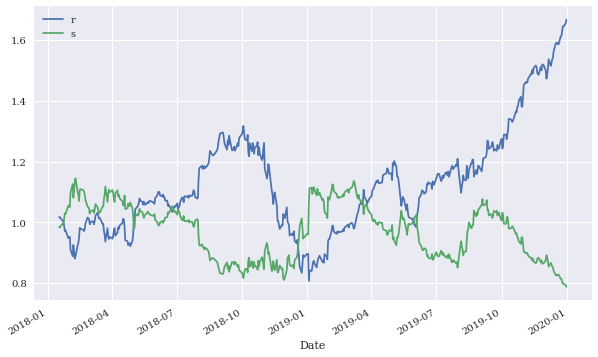

In [29]:
env.data[['r', 's']].iloc[env.lags:].cumsum(
            ).apply(np.exp).plot(figsize=(10, 6));

## Event-Based Backtesting

In [30]:
import backtesting as bt

In [31]:
bb = bt.BacktestingBase(env=agent.learn_env, model=agent.model,
                        amount=10000, ptc=0.0001, ftc=1.0,
                        verbose=True) 

In [32]:
bb.initial_amount

10000

In [33]:
bar = 100

In [34]:
bb.get_date_price(bar)

('2010-06-25', 38.0999619)

In [35]:
bb.env.get_state(bar)

,AAPL.O,r,s,m,v
Date,,,,,
2010-06-22,-1.2851,0.7775,-1.3297,1.1960,0.5284
2010-06-23,-1.2924,-0.7115,-1.3263,1.1362,0.5575
2010-06-24,-1.2974,-0.5091,-1.3231,1.0980,0.5724


In [36]:
bb.place_buy_order(bar, amount=5000)

2010-06-25 | buy 131 units for 38.1000
2010-06-25 | current balance = 5007.41


In [37]:
bb.print_net_wealth(2 * bar)

2010-11-16 | net wealth = 10651.44


In [38]:
bb.place_sell_order(2 * bar, units=1000)

2010-11-16 | sell 1000 units for 43.0842
2010-11-16 | current balance = 48086.34


In [39]:
bb.close_out(3 * bar)

2011-04-11 | *** CLOSING OUT ***
2011-04-11 | buy 869 units for 47.2571
2011-04-11 | current balance = 7014.82
2011-04-11 | net performance [%] = -29.8518
2011-04-11 | number of trades [#] = 3


In [40]:
env = learn_env

In [41]:
import tbbacktesterrm
tb = tbbacktesterrm.TBBacktesterRM(env, agent.model, 10000,
                  0.0, 0, verbose=False)

In [42]:
tb.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 70052.36
2017-01-12 | net performance [%] = 600.5236
2017-01-12 | number of trades [#] = 194


In [43]:
tb_ = tbbacktesterrm.TBBacktesterRM(env, agent.model, 10000,
                   0.00012, 0.0, verbose=False)

In [44]:
tb_.backtest_strategy()

2010-02-05 | *** START BACKTEST ***
2010-02-05 | current balance = 10000.00
2017-01-12 | *** CLOSING OUT ***
2017-01-12 | current balance = 68476.84
2017-01-12 | net performance [%] = 584.7684
2017-01-12 | number of trades [#] = 194


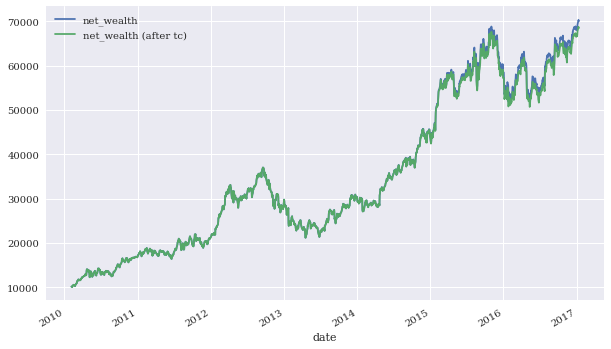

In [45]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);

In [46]:
env = test_env

In [47]:
tb = tbbacktesterrm.TBBacktesterRM(env, agent.model, 10000,
                  0.0, 0, verbose=False)

In [48]:
tb.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 6574.58
2019-12-31 | net performance [%] = -34.2542
2019-12-31 | number of trades [#] = 194


In [49]:
tb_ = tbbacktesterrm.TBBacktesterRM(env, agent.model, 10000,
                   0.00012, 0.0, verbose=False)

In [50]:
tb_.backtest_strategy()

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 6418.16
2019-12-31 | net performance [%] = -35.8184
2019-12-31 | number of trades [#] = 194


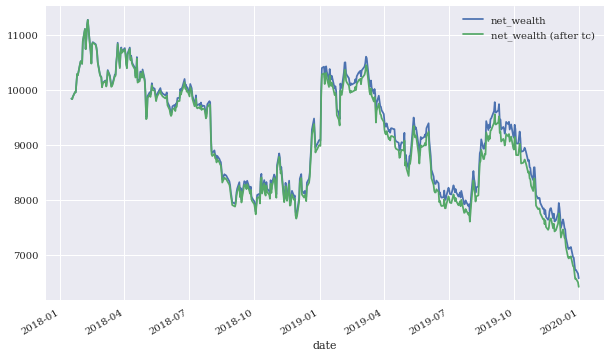

In [51]:
ax = tb.net_wealths.plot(figsize=(10, 6))
tb_.net_wealths.columns = ['net_wealth (after tc)']
tb_.net_wealths.plot(ax=ax);

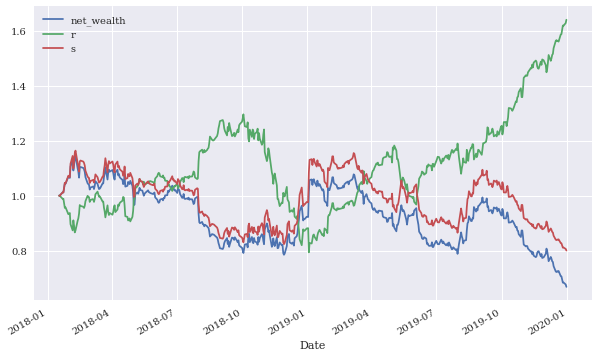

In [52]:
ax = (tb.net_wealths / tb.net_wealths.iloc[0]).plot(figsize=(10, 6))
tp = env.data[['r', 's']].iloc[env.lags:].cumsum().apply(np.exp)
(tp / tp.iloc[0]).plot(ax=ax);

## Assessing Risk

In [53]:
data = pd.DataFrame(learn_env.data[symbol])

In [54]:
data.head()

,AAPL.O
Date,
2010-02-02,27.9800
2010-02-03,28.4614
2010-02-04,27.4357
2010-02-05,27.9228
2010-02-08,27.7314


In [55]:
window = 14

In [56]:
data['min'] = data[symbol].rolling(window).min()
data['max'] = data[symbol].rolling(window).max()
data['mami'] = data['max'] - data['min']
data['mac'] = abs(data['max'] - data[symbol].shift(1))
data['mic'] = abs(data['min'] - data[symbol].shift(1))
data['atr'] = np.maximum(data['mami'], data['mac'])
data['atr'] = np.maximum(data['atr'], data['mic'])
data['atr%'] = data['atr'] / data[symbol]


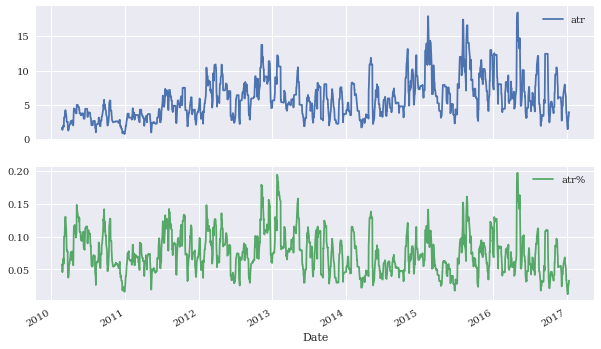

In [57]:
data[['atr', 'atr%']].plot(subplots=True, figsize=(10, 6));

In [58]:
data[['atr', 'atr%']].tail()

,atr,atr%
Date,,
2017-01-06,2.0900,0.0177
2017-01-09,3.1700,0.0266
2017-01-10,3.2900,0.0276
2017-01-11,3.9300,0.0328
2017-01-12,3.9300,0.0330


In [59]:
leverage = 10

In [60]:
data[['atr', 'atr%']].tail() * leverage

,atr,atr%
Date,,
2017-01-06,20.9000,0.1773
2017-01-09,31.7000,0.2664
2017-01-10,32.9000,0.2762
2017-01-11,39.3000,0.3282
2017-01-12,39.3000,0.3296


In [61]:
data[['atr', 'atr%']].median() * leverage

atr    53.7342
atr%    0.7043
dtype: float64

## Backtesting Risk Measures

In [62]:
import tbbacktesterrm as tbbrm

In [63]:
env = test_env

In [64]:
tb = tbbrm.TBBacktesterRM(env, agent.model, 10000,
                          0.0, 0, verbose=False)

In [65]:
tb.backtest_strategy(sl=None, tsl=None, tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 6574.58
2019-12-31 | net performance [%] = -34.2542
2019-12-31 | number of trades [#] = 194


### Stop Loss

In [66]:
tb.backtest_strategy(sl=0.45, tsl=None, tp=None,
                     wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
2019-12-31 | *** CLOSING OUT ***
2019-12-31 | current balance = 6574.58
2019-12-31 | net performance [%] = -34.2542
2019-12-31 | number of trades [#] = 194


In [67]:
tb.backtest_strategy(sl=0.001, tsl=None, tp=None,
                     wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0010) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0010) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0010) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0010) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0010) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0010) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0010) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0010) ***
--------------------------------------------------
*** STOP LOSS (SHORT | -0.0010) ***
--------------------------------------------------
*** STOP LOSS (LONG  | -0.0010) ***
--------------------------------------------------
***

### Trailing Stop Loss

In [68]:
tb.backtest_strategy(sl=None, tsl=.0015,
                     tp=None, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0174) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0026) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0077) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0079) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0190) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0180) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0447) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0296) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0051) ***
--------------------------------------------------
*** TRAILING SL (LONG  | -0.0438) ***
----------------------------------

### Take Profit

In [69]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.00015,
                     wait=5, guarantee=False)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0112) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0387) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0487) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0004) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0101) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0188) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0289) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0172) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0081) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0468) ***
--------------------------------------------

In [70]:
tb.backtest_strategy(sl=None, tsl=None, tp=0.045,
                     wait=5, guarantee=True)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0450) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0450) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0450) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0450) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0450) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0450) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0450) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0450) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0450) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0450) ***
--------------------------------------------

## Combinations

In [71]:
tb.backtest_strategy(sl=0.08, tsl=None,
                     tp=0.000185, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0112) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0387) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0487) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0004) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0101) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0188) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0289) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0172) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0081) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0468) ***
--------------------------------------------

In [72]:
tb.backtest_strategy(sl=None, tsl=0.085,
                     tp=0.02, wait=5)

2018-01-17 | *** START BACKTEST ***
2018-01-17 | current balance = 10000.00
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0288) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0414) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0487) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0286) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0379) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0289) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0574) ***
--------------------------------------------------
*** TAKE PROFIT (LONG  | 0.0411) ***
--------------------------------------------------
*** TAKE PROFIT (SHORT | 0.0305) ***
--------------------------------------------------
*** TRAILING SL (SHORT | -0.0950) ***
-------------------------------------------